In [1]:
%matplotlib inline
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

In [2]:
print(tf.__version__)

2.8.0


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.resnet50 import preprocess_input as ResNet_Pre
from tensorflow.keras.applications.densenet import preprocess_input as DenseNet_Pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as Inception_Pre
from tensorflow.keras.applications.xception import preprocess_input as Xception_Pre
from tensorflow.keras.applications.efficientnet import preprocess_input as EfficientNet_Pre

In [5]:
model_ResNet = ResNet50(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [6]:
# model_DenseNet121 = DenseNet121(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_DenseNet121.summary()

In [7]:
model_DenseNet201 = DenseNet201(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_DenseNet201.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [8]:
# model_InceptionV3 = InceptionV3(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_InceptionV3.summary()

In [9]:
# model_Xception = Xception(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_Xception.summary()

In [10]:
# model_EfficientNetV2S = EfficientNetV2S(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model_EfficientNetV2S.summary()

In [11]:
model_EfficientNetB5 = EfficientNetB5(weights="imagenet", include_top=False, pooling='avg', input_shape=(224, 224, 3))
model_EfficientNetB5.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [12]:
classes = ["Insulator", "Nest", "Bolt", "Missing_Bolt", "Spacer"]

In [13]:
folder = "Power(ALLcroppedManual)"
q_batch_size = 32

q_directory = "D:\ExtraCources\SummerInter\FewShot\Test\QuerySets\FewShotQuery_" + folder

q_data = tf.keras.preprocessing.image_dataset_from_directory(
    q_directory,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=q_batch_size,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
)

print(len(q_data))

Found 160 files belonging to 5 classes.
5


In [14]:
def make_conf_mat(model, q_full_features, q_labels):
    y_pred = tf.argmax(model.predict(q_full_features, batch_size=15, verbose=0), axis=1)
    y_true = tf.argmax(q_labels, axis=1)
    # test_scores = model.evaluate(q_full_features, q_labels, verbose=0)
    
    conf = tf.math.confusion_matrix(y_true, y_pred).numpy()

    conf_mat_df = pd.DataFrame(conf, index = classes, columns = classes)
    
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(conf_mat_df, annot=True, cmap=plt.cm.Greens)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.title(test_scores)
    
    plt.show()

In [15]:
def make_model(input_size=(4, 4, 376), learning_rate=5e-4, nway=5, l2_regu_const=0.5):
    
    keras.backend.clear_session()
    model = keras.Sequential()
    
    model.add(keras.Input(shape=input_size))
    # 4, 4, 376 
    model.add(keras.layers.Conv2D(512,3,strides=(1, 1),padding="same",activation='relu'))
    # 4, 4, 512
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.AveragePooling2D(pool_size=4, strides=None, padding="valid"))
    # 1, 1, 512
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(nway, kernel_regularizer=keras.regularizers.L2(l2_regu_const), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    return model

Split number : 1
Epoch 1/300
1/1 [==============================] - 0s 413ms/step - loss: 6.1379 - accuracy: 0.2400
Epoch 2/300
1/1 [==============================] - 0s 31ms/step - loss: 5.6549 - accuracy: 0.7600
Epoch 3/300
1/1 [==============================] - 0s 34ms/step - loss: 5.3311 - accuracy: 0.9200
Epoch 4/300
1/1 [==============================] - 0s 30ms/step - loss: 5.0958 - accuracy: 0.9200
Epoch 5/300
1/1 [==============================] - 0s 28ms/step - loss: 4.9209 - accuracy: 0.9600
Epoch 6/300
1/1 [==============================] - 0s 29ms/step - loss: 4.7875 - accuracy: 0.9600
Epoch 7/300
1/1 [==============================] - 0s 30ms/step - loss: 4.6723 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 28ms/step - loss: 4.5752 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 29ms/step - loss: 4.4974 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 29ms/step - loss: 4.4401 - accuracy: 1.0000
E

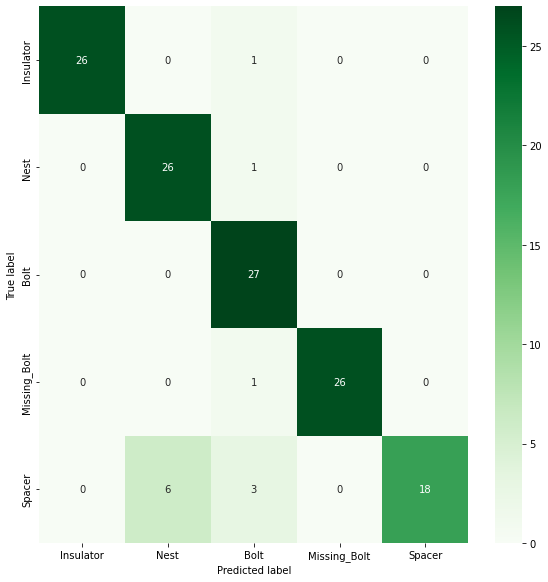

Split number : 2
Epoch 1/300
1/1 [==============================] - 0s 384ms/step - loss: 6.4454 - accuracy: 0.2400
Epoch 2/300
1/1 [==============================] - 0s 30ms/step - loss: 5.9213 - accuracy: 0.8400
Epoch 3/300
1/1 [==============================] - 0s 31ms/step - loss: 5.5741 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 31ms/step - loss: 5.3198 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 29ms/step - loss: 5.1284 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 28ms/step - loss: 4.9949 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 29ms/step - loss: 4.8973 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 29ms/step - loss: 4.8265 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 29ms/step - loss: 4.7717 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 30ms/step - loss: 4.7295 - accuracy: 1.0000
E

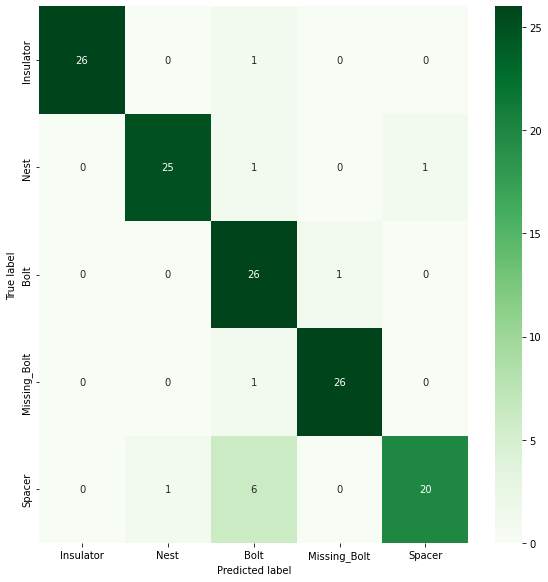

Split number : 3
Epoch 1/300
1/1 [==============================] - 0s 384ms/step - loss: 5.8571 - accuracy: 0.2400
Epoch 2/300
1/1 [==============================] - 0s 32ms/step - loss: 5.2549 - accuracy: 1.0000
Epoch 3/300
1/1 [==============================] - 0s 32ms/step - loss: 4.8771 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 32ms/step - loss: 4.6112 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 30ms/step - loss: 4.4287 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 30ms/step - loss: 4.3106 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 29ms/step - loss: 4.2325 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 29ms/step - loss: 4.1803 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 28ms/step - loss: 4.1442 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 29ms/step - loss: 4.1175 - accuracy: 1.0000
E

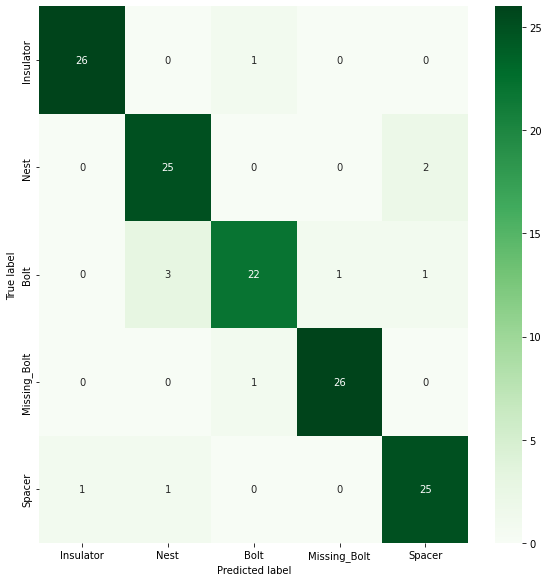

Split number : 4
Epoch 1/300
1/1 [==============================] - 0s 376ms/step - loss: 5.9535 - accuracy: 0.2000
Epoch 2/300
1/1 [==============================] - 0s 31ms/step - loss: 5.4225 - accuracy: 0.8000
Epoch 3/300
1/1 [==============================] - 0s 30ms/step - loss: 5.0848 - accuracy: 0.8000
Epoch 4/300
1/1 [==============================] - 0s 30ms/step - loss: 4.8613 - accuracy: 0.8400
Epoch 5/300
1/1 [==============================] - 0s 29ms/step - loss: 4.7149 - accuracy: 0.8400
Epoch 6/300
1/1 [==============================] - 0s 29ms/step - loss: 4.6178 - accuracy: 0.8400
Epoch 7/300
1/1 [==============================] - 0s 30ms/step - loss: 4.5500 - accuracy: 0.9200
Epoch 8/300
1/1 [==============================] - 0s 30ms/step - loss: 4.4982 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 29ms/step - loss: 4.4562 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 29ms/step - loss: 4.4163 - accuracy: 1.0000
E

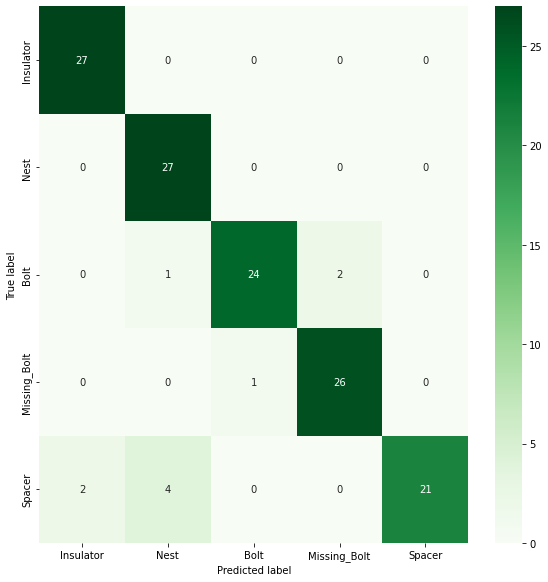

Split number : 5
Epoch 1/300
1/1 [==============================] - 0s 383ms/step - loss: 6.4491 - accuracy: 0.2500
Epoch 2/300
1/1 [==============================] - 0s 26ms/step - loss: 5.8839 - accuracy: 0.9500
Epoch 3/300
1/1 [==============================] - 0s 27ms/step - loss: 5.5163 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 26ms/step - loss: 5.2501 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 24ms/step - loss: 5.0718 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 24ms/step - loss: 4.9507 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 25ms/step - loss: 4.8636 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 25ms/step - loss: 4.7985 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 24ms/step - loss: 4.7497 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 24ms/step - loss: 4.7132 - accuracy: 1.0000
E

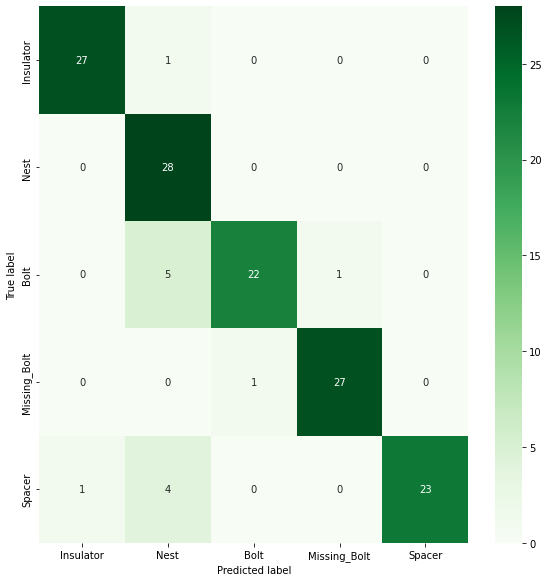

Split number : 6
Epoch 1/300
1/1 [==============================] - 0s 385ms/step - loss: 6.3008 - accuracy: 0.2500
Epoch 2/300
1/1 [==============================] - 0s 26ms/step - loss: 5.5722 - accuracy: 0.9500
Epoch 3/300
1/1 [==============================] - 0s 26ms/step - loss: 5.1709 - accuracy: 0.9500
Epoch 4/300
1/1 [==============================] - 0s 27ms/step - loss: 4.9164 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 26ms/step - loss: 4.7621 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 25ms/step - loss: 4.6673 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 24ms/step - loss: 4.6061 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 25ms/step - loss: 4.5641 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 24ms/step - loss: 4.5333 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 24ms/step - loss: 4.5089 - accuracy: 1.0000
E

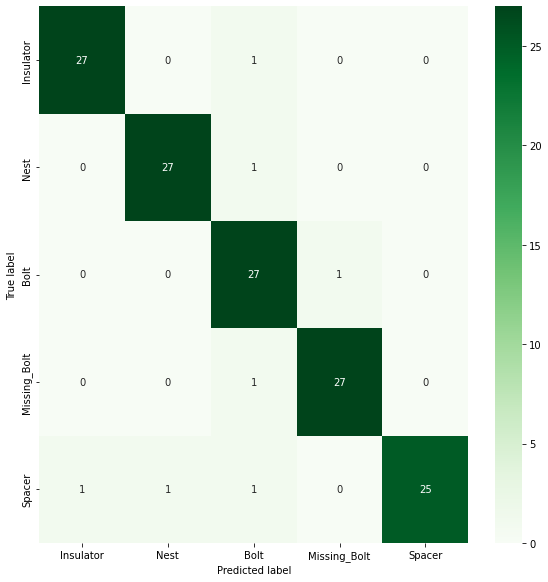

Split number : 7
Epoch 1/300
1/1 [==============================] - 0s 369ms/step - loss: 6.0075 - accuracy: 0.3000
Epoch 2/300
1/1 [==============================] - 0s 25ms/step - loss: 5.4256 - accuracy: 1.0000
Epoch 3/300
1/1 [==============================] - 0s 25ms/step - loss: 5.0452 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 25ms/step - loss: 4.7722 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 24ms/step - loss: 4.5870 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 24ms/step - loss: 4.4671 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 23ms/step - loss: 4.3897 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 23ms/step - loss: 4.3393 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 23ms/step - loss: 4.3048 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 23ms/step - loss: 4.2789 - accuracy: 1.0000
E

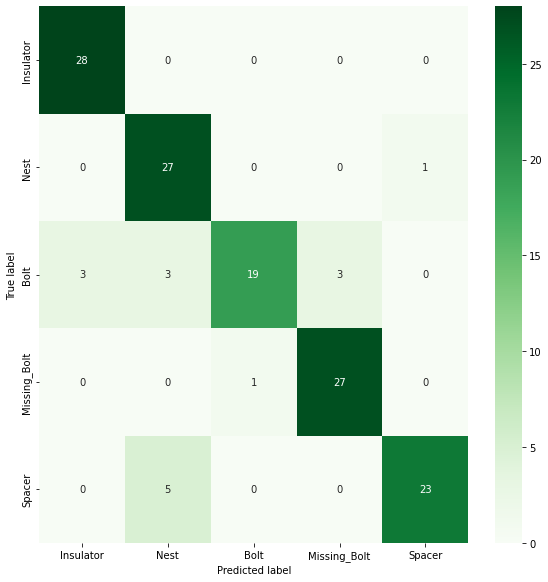

In [16]:
k = 0
running_acc = 0

j = 0


arr = np.empty(32)
k_fold = KFold(n_splits=7, shuffle=True, random_state=42)

for train_indices, test_indices in k_fold.split(arr):
    
    k += 1
    print("Split number : {}".format(k))
    
    # print('Train: %s | test: %s' % (train_indices, test_indices))

    sup_set = None
    sup_lab = None
    
    q_set = None
    q_lab = None
    
    
    for q in q_data.__iter__():
           
        temp_sup = tf.gather(q[0], test_indices)
        temp_sup_lab = tf.gather(q[1], test_indices)
        
        temp_q = tf.gather(q[0], train_indices)
        temp_q_lab = tf.gather(q[1], train_indices)
        
        if sup_set is None:
            sup_set = temp_sup
        else:
            sup_set = tf.concat([sup_set, temp_sup], 0)
        
        if sup_lab is None:
            sup_lab = temp_sup_lab
        else:
            sup_lab = tf.concat([sup_lab, temp_sup_lab], 0)
            
        if q_set is None:
            q_set = temp_q
        else:
            q_set = tf.concat([q_set, temp_q], 0)
            
        if q_lab is None:
            q_lab = temp_q_lab
        else:
            q_lab = tf.concat([q_lab, temp_q_lab], 0)
        
    
    # break
    

    channels = 32 * 4 + 62 * 4
    size = 4

    img_pre_res = ResNet_Pre(sup_set)
    res_features = model_ResNet(img_pre_res)
    
    # img_pre_dense = DenseNet_Pre(sup_set)
    # dense_features121 = model_DenseNet121(img_pre_dense)
    
    img_pre_dense = DenseNet_Pre(sup_set)
    dense_features201 = model_DenseNet201(img_pre_dense)
    
    # img_pre_inception = Inception_Pre(sup_set)
    # inception_features = model_InceptionV3(img_pre_inception)
    
    # img_pre_xception = Xception_Pre(sup_set)
    # xception_features = model_Xception(img_pre_xception)
    
    # img_pre_efficientv2s = EfficientNet_Pre(sup_set)
    # efficientv2s_features = model_EfficientNetV2S(img_pre_efficientv2s)
    
    img_pre_efficientb5 = EfficientNet_Pre(sup_set)
    efficientb5_features = model_EfficientNetB5(img_pre_efficientb5)
    
    
    full_features = tf.concat([res_features, dense_features201, efficientb5_features], axis=1)
    
    # full_features = efficientb5_features
    
    labels = sup_lab
    
    
    
    q_img_res_pre = ResNet_Pre(q_set)
    q_res_features = model_ResNet(q_img_res_pre)
    
    # q_img_dense_pre = DenseNet_Pre(q_set)
    # q_dense_features121 = model_DenseNet121(q_img_dense_pre)
    
    q_img_dense_pre = DenseNet_Pre(q_set)
    q_dense_features201 = model_DenseNet201(q_img_dense_pre)
    
    # q_img_inception_pre = Inception_Pre(q_set)
    # q_inception_features = model_InceptionV3(q_img_inception_pre)
    
    # q_img_xception_pre = Xception_Pre(q_set)
    # q_xception_features = model_Xception(q_img_xception_pre)
    
    # q_img_efficientv2s_pre = EfficientNet_Pre(q_set)
    # q_efficientv2s_features = model_EfficientNetV2S(q_img_efficientv2s_pre)
    
    q_img_efficientb5_pre = EfficientNet_Pre(q_set)
    q_efficientb5_features = model_EfficientNetB5(q_img_efficientb5_pre)
    
    
    q_full_features = tf.concat([q_res_features, q_dense_features201, q_efficientb5_features], axis=1)
    
    # q_full_features = q_efficientb5_features
    
    q_labels = q_lab
    
    
    # break
    
    conv_ini = tf.reshape(full_features, (len(test_indices)*5,size, size, channels))
    
    q_conv_ini = tf.reshape(q_full_features, (len(train_indices)*5, size, size, channels))
    
    # break
    
    model = make_model(input_size=(size, size, channels))
    
    
    epochs = 300
    batch_size = 5 * 5
    
    history = model.fit(conv_ini, labels, batch_size=batch_size, epochs=epochs, validation_split=0, verbose=1, shuffle=False)
    
    test_scores = model.evaluate(q_conv_ini, q_labels, verbose=0)
    

    running_acc += test_scores[1]
    
    print("Accuracy on query set for split number {} is : {}".format(k, test_scores[1]))
    print("Average accuracy till now is : {}".format(running_acc / k))
    
    make_conf_mat(model, q_conv_ini, q_labels)
    
    # j += 1
    
    # if j == 2:
    #     break

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 512)         1733120   
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [19]:
y_pred = tf.argmax(model.predict(q_conv_ini, batch_size=15, verbose=1), axis=1)
y_true = tf.argmax(q_labels, axis=1)
uneq = (y_pred != y_true).numpy()
# print(uneq)
e = [i for i in range(len(uneq)) if uneq[i] == True]
# print(e)
print(len(e))

10/10 [==============================] - 0s 4ms/step
16


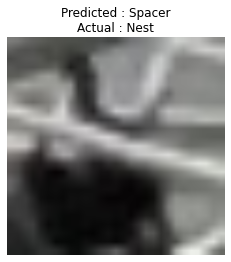

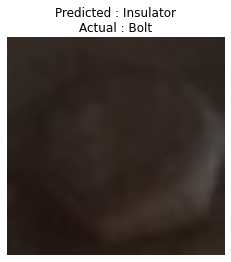

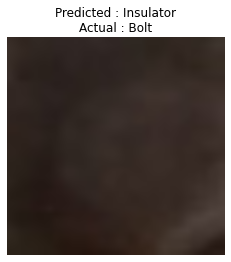

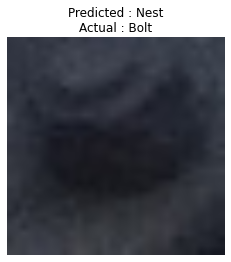

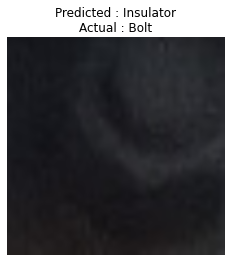

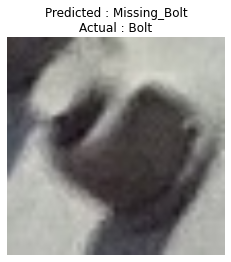

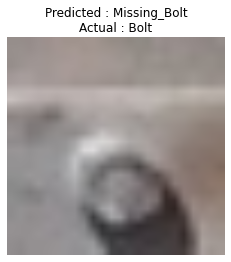

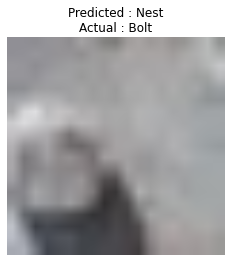

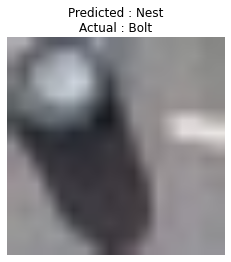

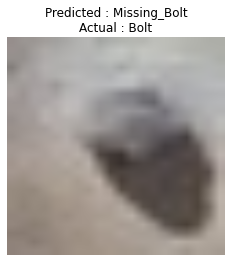

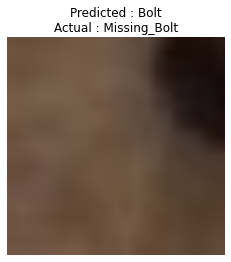

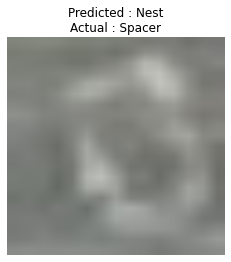

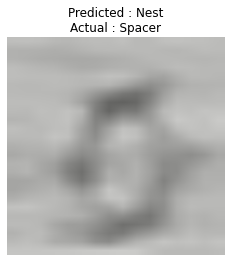

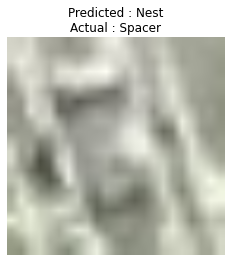

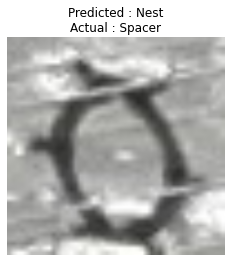

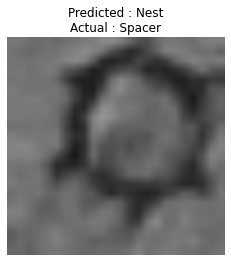

In [20]:
# i = 7
for i in range(len(e)):
    plt.figure()
    plt.axis("off")
    plt.imshow(q_set[e[i]] / 255)
    plt.title("Predicted : {}\nActual : {}".format(classes[y_pred[e[i]]], classes[y_true[e[i]]]))
    
    # print("Predicted : {}".format(classes[y_pred[e[i]]]))
    # print("Actual : {}".format(classes[y_true[e[i]]]))

['Insulator', 'Nest', 'Bolt', 'Missing_Bolt', 'Spacer']


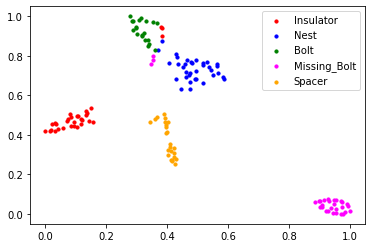

In [27]:
model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
# test_ds = np.concatenate(list(train_ds.take(5).map(lambda x, y : x))) # get five batches of images and convert to numpy array

q_features2 = model2(q_conv_ini)
labels = tf.argmax(model.predict(q_conv_ini, batch_size=15, verbose=0), axis=1)
tsne = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(q_features2)

def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

colors = ['red', 'blue', 'green', 'magenta', 'orange']
# classes = q_full_features.class_names  
print(classes)
fig = plt.figure()
ax = fig.add_subplot(111)
for idx, c in enumerate(colors):
    indices = [i for i, l in enumerate(labels) if idx == l]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    ax.scatter(current_tx, current_ty, s=10, c=c, label=classes[idx])

ax.legend(loc='best')
plt.show()

In [22]:
def print_plots(history):
        
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper right')
  plt.show()

  plt.figure()
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper right')
  plt.show()

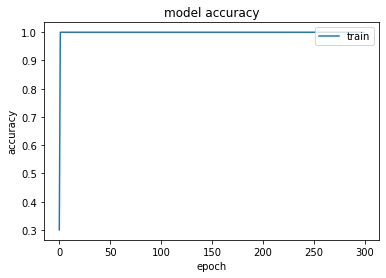

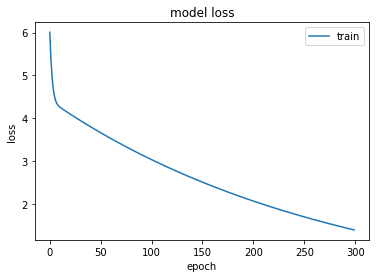

In [23]:
print_plots(history)

In [24]:
# model.save("D:\ExtraCources\SummerInter\FewShot\Test\SavedModels\TF_conv_model_RN_DN_EN")